In [12]:
import sys
sys.path.append('../')
from src.dataset import read_folder
import cv2
from src.visualization import plot_img
from skimage.segmentation import slic
import numpy as np
import matplotlib.pyplot as plt
import copy

In [13]:
sys.path.append('../SkinDetection')

In [18]:
# load it twice
from ipynb.fs.defs.skinDetectionWithFaceLandmarks import find_skin_mask_with_eyebrowns_consider_roi_one_segment
from ipynb.fs.defs.skinDetectionWithFaceLandmarks import improve_face_mask_using_morphology
from ipynb.fs.defs.skinDetectionWithFaceLandmarks import find_the_large_segement_covered_by_base_mask

In [19]:
PATH = '../LaPa/examples'
images = read_folder(PATH, n = None)

In [20]:
def countour_mask(mask):
    contours, hierarchy = cv2.findContours(np.uint8(mask), 1, 2)

    cnt = contours[0]
    max_area = cv2.contourArea(cnt)

    for contour in contours:
        if cv2.contourArea(contour) > max_area:
            cnt = contour[:,0]
            max_area = cv2.contourArea(contour)
            
    return cnt

In [21]:
def forehead_line(landmarks, cnt):
    left_face_side = landmarks()[landmarks.points_info['LEFT_FACE_SIDE']]
    reight_face_side = landmarks()[landmarks.points_info['REIGHT_FACE_SIDE']] 
    
    forehead_line = np.concatenate( [cnt[(cnt < [left_face_side[:,0].max(), left_face_side[:,1][5]]).all(axis = 1)],
                               cnt[(cnt[:,0] > [reight_face_side[:,0].min()] ) * (cnt[:,1] < [reight_face_side[:,1][4]])]])
    
    return forehead_line

In [22]:
def find_n_points_in_countour(countour, n: int = 10, perimeter = True):
    n_points = []
    if perimeter:
        perimeter = ((np.diff(countour, axis = 0)**2).sum(axis = 1)**(1/2)).sum() #prawie to samo co perimeter = cv2.arcLength(cnt,True)
        diff_perimeter = ((np.diff(countour, axis = 0)**2).sum(axis = 1)**(1/2)).cumsum()
        for i in range(n):
            n_points.append(max([-1, *np.where(diff_perimeter < perimeter/n*i)[0]]) + 1)
    else:
        L = len(countour)
        for i in range(n):
            n_points.append(int(i*L/n))
    return n_points

In [23]:
def update_landmarks(forehead_points, landmarks):
    the_highest_point = forehead_points[list(forehead_points[:,1]).index(min(forehead_points[:,1]))]
    nose_point = landmarks()[landmarks.points_info['NOSE_LINE_POINTS']][0]
    diff =  the_highest_point - nose_point
    midle_point = nose_point + (diff/2).astype(int)
    new_landmarks = copy.copy(landmarks)
    new_landmarks.points_info['FOREHEAD'] = list(range(len(landmarks()), len(landmarks()) + len(forehead_points) + 1))
    new_landmarks.landmarks_array = np.concatenate([landmarks.landmarks_array, forehead_points, np.array([midle_point])])
    return new_landmarks

In [26]:
example_img = list(images.keys())[5]
img_BGR = images[example_img]['img']
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

In [40]:
mask, _, landmarks = find_skin_mask_with_eyebrowns_consider_roi_one_segment(img_BGR, morphology = True, treshold_sd = 0, n_segments = 10)

In [41]:
list(range(len(landmarks()) , len(landmarks()) + 10 + 1))

[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]

In [42]:
len(landmarks())

68

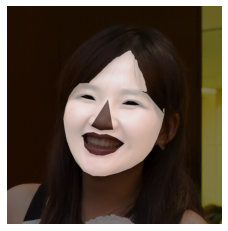

In [43]:
plot_img(img_RGB)
plot_img(mask, alpha = 0.5, cmap = 'gray')

In [44]:
cnt = countour_mask(mask)

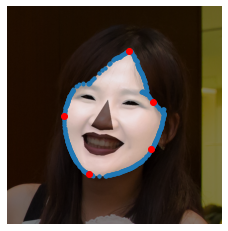

In [45]:
# punkty można w zaleznosci od ntego punkta
n = 5
plot_img(img_RGB)
plt.plot(cnt[:,0], cnt[:,1], '.')
k = find_n_points_in_countour(cnt, n = n, perimeter = False)
plt.plot(cnt[:,0][k], cnt[:,1][k], 'ro')
plot_img(mask, alpha = 0.5, cmap = 'gray')

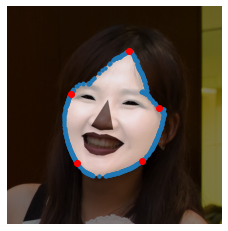

In [46]:
# punkty można w zaleznosci od odległości
n = 5
plot_img(img_RGB)
plt.plot(cnt[:,0], cnt[:,1], '.')
k = find_n_points_in_countour(cnt, n = n, perimeter = True)
plt.plot(cnt[:,0][k], cnt[:,1][k], 'ro')
plot_img(mask, alpha = 0.5, cmap = 'gray')

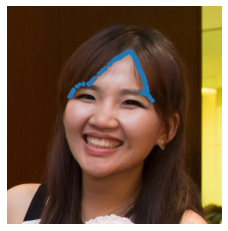

In [47]:
forehead = forehead_line(landmarks, cnt)
plot_img(img_RGB)
plt.plot(forehead[:,0], forehead[:,1], '.')

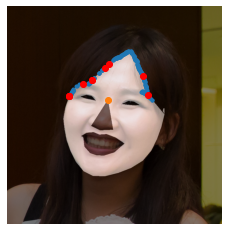

In [48]:
# punkty można w zaleznosci od odległości
k = find_n_points_in_countour(forehead, n = 10, perimeter = True)

plot_img(img_RGB)
plt.plot(forehead[:,0], forehead[:,1], '.')
plt.plot(forehead[:,0][k], forehead[:,1][k], 'ro')
plt.plot( landmarks()[landmarks.points_info['NOSE_LINE_POINTS']][0][0],  landmarks()[landmarks.points_info['NOSE_LINE_POINTS']][0][1], 'o')
plot_img(mask, alpha = 0.5, cmap = 'gray')

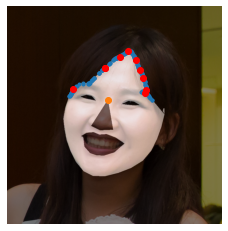

In [49]:
# punkty można w zaleznosci od ntego punkta
k = find_n_points_in_countour(forehead, n = 10, perimeter = False)

plot_img(img_RGB)
plt.plot(forehead[:,0], forehead[:,1], '.')
plt.plot(forehead[:,0][k], forehead[:,1][k], 'ro')
plt.plot( landmarks()[landmarks.points_info['NOSE_LINE_POINTS']][0][0],  landmarks()[landmarks.points_info['NOSE_LINE_POINTS']][0][1], 'o')
plot_img(mask, alpha = 0.5, cmap = 'gray')

In [50]:
new_landmarks = update_landmarks(forehead[k], landmarks)

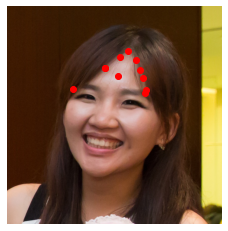

In [51]:
plot_img(img_RGB)
new_k = landmarks.points_info['FOREHEAD']
plt.plot(new_landmarks()[:,0][new_k], new_landmarks()[:,1][new_k], 'ro')